<a href="https://colab.research.google.com/github/g-aditi/customer-personality-analysis/blob/main/CustomerPersonalityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install dataprep
from dataprep.eda import plot, plot_correlation, create_report, plot_missing

In [5]:

df = pd.read_csv('/content/drive/MyDrive/Kaggle/customer-personality-analysis.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# **Exploratory Data Analysis**



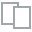
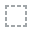
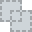
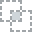
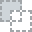
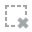
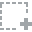
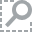
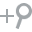
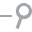
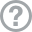
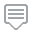
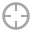
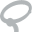
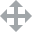
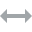
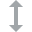
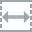
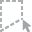
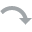
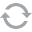
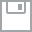
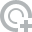
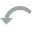
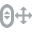
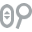
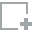
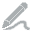
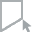
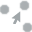
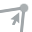
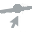

In [6]:
plot(df)

From these graphs, we observe some inaccuracies - the starting range for the Year_Birth feature is 1890. It is amusing to think people would be shopping online in that era! That being said, this data requires some cleaning, and some redefinition of scales, as in, the Income feature seems to have too many values of negligible frequency. From the insights gained above, we see that the Income feature has some NULL values, which we will replace with the median value for better results.

In [7]:
clean_df = df.drop(df[(df['Year_Birth'] < 1935) |
                      (df['Income'] > 175000)].index)
clean_df['Income'].fillna(clean_df['Income'].median(), inplace=True)

A handy feature to know would be the total amount of money each customer spends. This can be found out by adding all the individual amounts spent on wines, fruits, meat products, etc. Similarly, it would also be useful to know how many purchases have been made by each customer.

In [8]:
clean_df['Total_Expenditure'] = clean_df.filter(like='Mnt').sum(axis=1)
clean_df['Total_Purchases'] = clean_df.filter(regex='Num[^Deals].+Purchases').sum(axis=1)

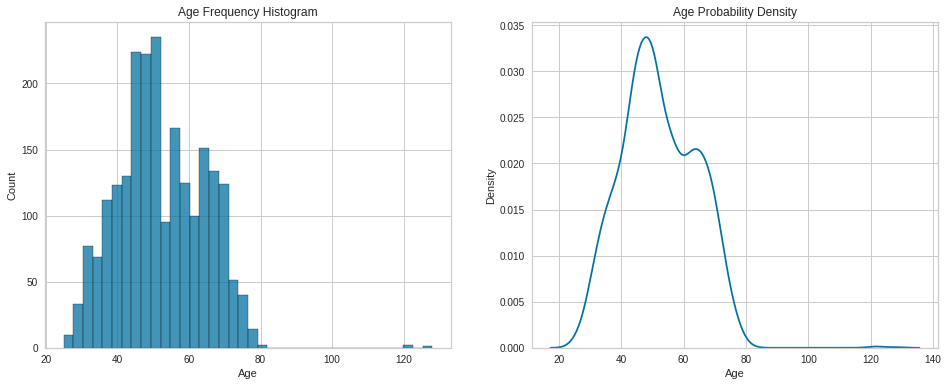

In [9]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
currentYear = datetime.datetime.now()
df['Age'] = currentYear.year - df['Year_Birth']
sns.histplot(df['Age'], ax=axes[0]).set(title='Age Frequency Histogram')
sns.kdeplot(df['Age'], ax=axes[1]).set(title='Age Probability Density')
fig.show()

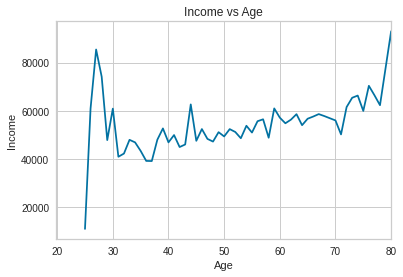

In [10]:
income_vs_age = sns.lineplot(x="Age", y="Income", data=df, ci=None)
income_vs_age.set(xlim=(None, 80), title='Income vs Age')
income_vs_age

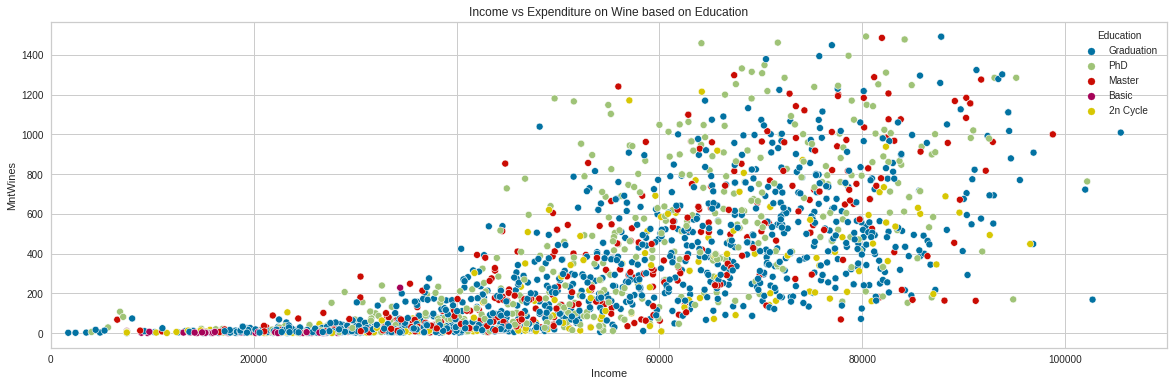

In [11]:
plt.figure(figsize=(20,6))
edu_vs_wine = sns.scatterplot(x="Income", y="MntWines", data=df, hue="Education")
edu_vs_wine.set(xlim=(0, 110000), title="Income vs Expenditure on Wine based on Education")
edu_vs_wine

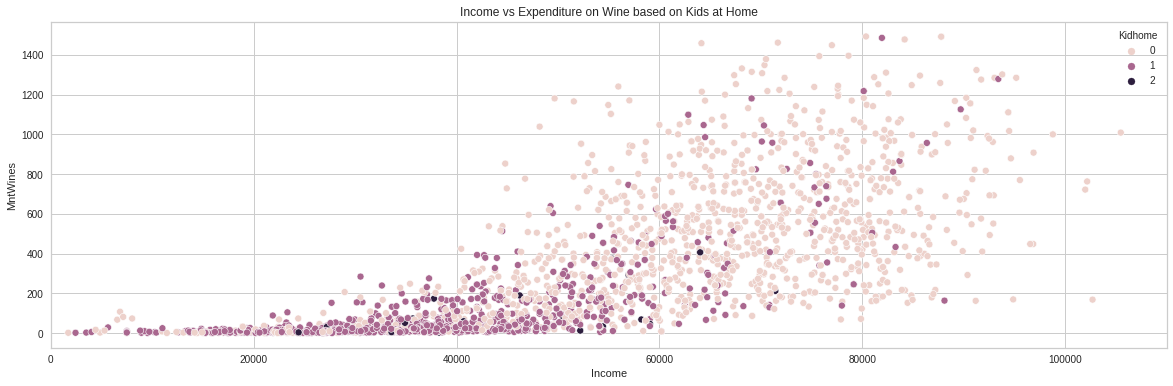

In [12]:
plt.figure(figsize=(20,6))
edu_vs_wine_kidhome = sns.scatterplot(x="Income", y="MntWines", data=df, hue="Kidhome")
edu_vs_wine_kidhome.set(xlim=(0, 110000), title="Income vs Expenditure on Wine based on Kids at Home")
edu_vs_wine_kidhome

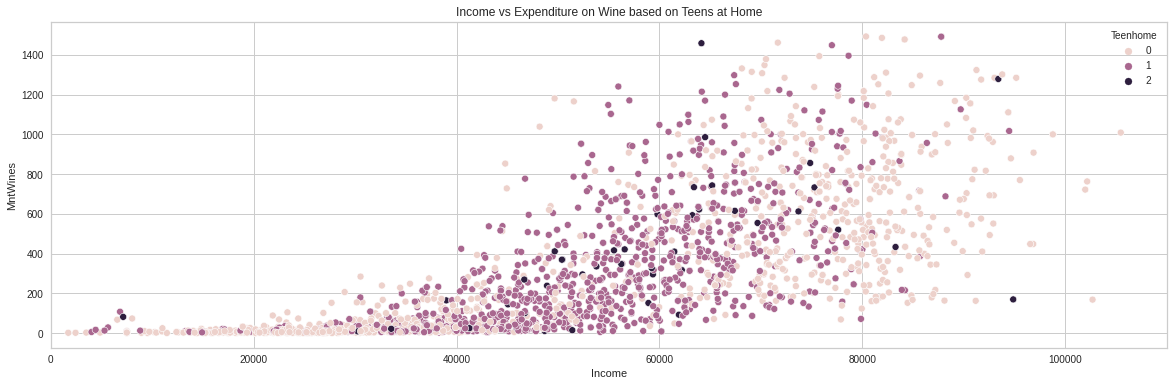

In [13]:
plt.figure(figsize=(20,6))
edu_vs_wine_teenhome = sns.scatterplot(x="Income", y="MntWines", data=df, hue="Teenhome")
edu_vs_wine_teenhome.set(xlim=(0, 110000), title="Income vs Expenditure on Wine based on Teens at Home")
edu_vs_wine_teenhome

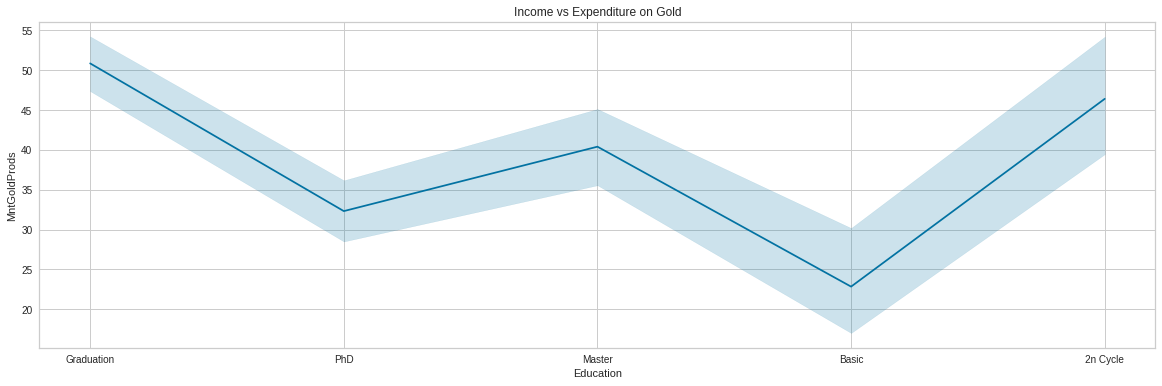

In [14]:
plt.figure(figsize=(20,6))
income_vs_gold = sns.lineplot(x="Education", y="MntGoldProds", data=df)
income_vs_gold.set(title="Income vs Expenditure on Gold")
income_vs_gold

# **KMeans Clustering**

The principle of KMeans Clustering is that the features be divided into K clusters in a way that each observation is belongs to the cluster having the nearest mean, or centroid. An important consideration for applying any clustering algorithm is to determine the 'k' that will yield the most accurate results. This can be done in many ways; some of the popular methods include:


1.   The Elbow Method
2.   The Silhouette Method



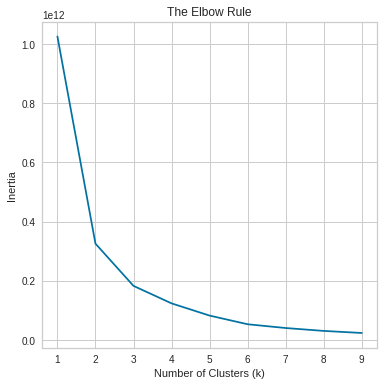

In [15]:
# Applying the Elbow method

inertias = []
possible_k_values = range(1,10)
features = ['Income', 'Total_Expenditure', 'Total_Purchases']

for k in possible_k_values:
   model = KMeans(k, random_state=20, init='k-means++').fit(clean_df[features])
   inertias.append(model.inertia_)


plt.figure(figsize=(6,6))    
plt.title("The Elbow Rule")
plt.plot(possible_k_values, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia');

We do not obtain a sharp elbow point, as observed in the graph above. A good k value can be either 4 or 5. Further clarification can be obtained by performing the Silhouette Method.

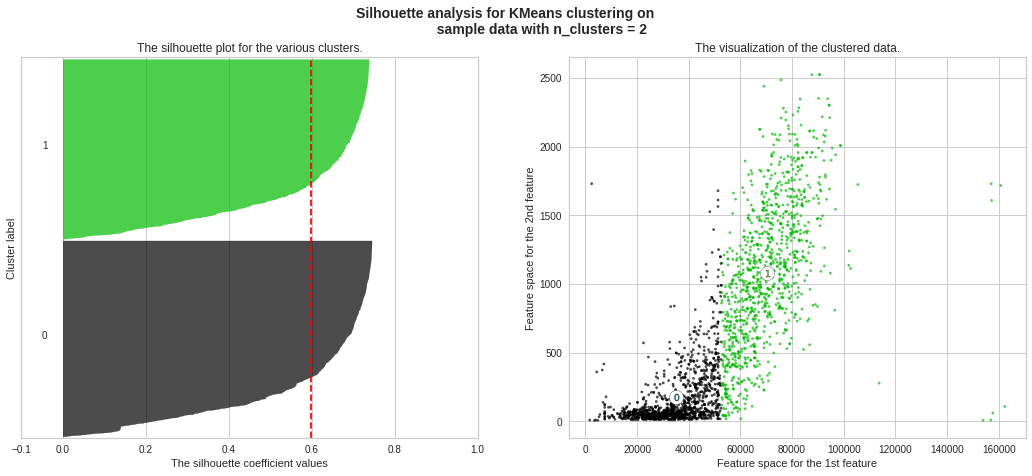

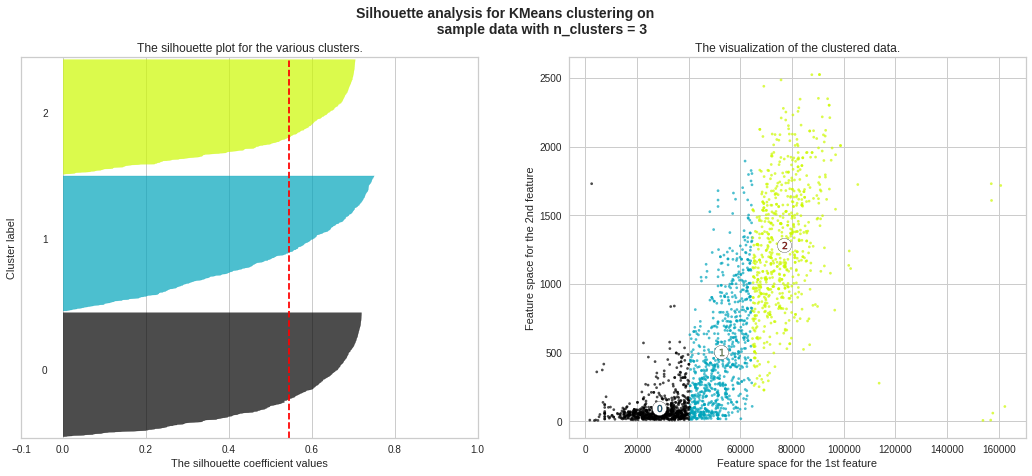

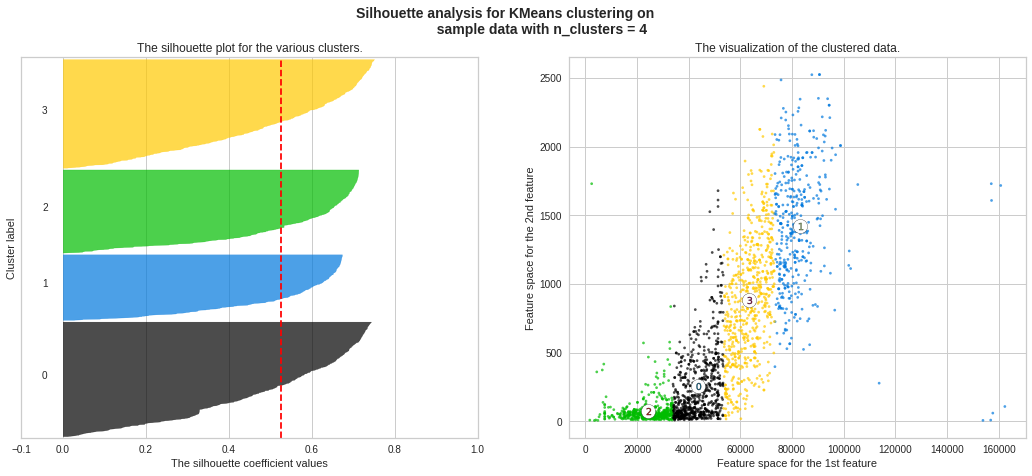

In [16]:
# Applying the Silhouette method

reduced_possible_k_values = range(2,5)

for k in reduced_possible_k_values:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(clean_df[features]) + (k + 1) * 10])

    model = KMeans(n_clusters=k, random_state=10)
    cluster_labels = model.fit_predict(clean_df[features])
    silhouette_avg = silhouette_score(clean_df[features], cluster_labels)
    sample_silhouette_values = silhouette_samples(clean_df[features], cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                          ith_cluster_silhouette_values, facecolor=color,
                          edgecolor=color, alpha=0.7,)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(clean_df[features].iloc[:, 0], clean_df[features].iloc[:, 1], 
                marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = model.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k",)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle('''Silhouette analysis for KMeans clustering on 
                  sample data with n_clusters = %d'''
                  % k, fontsize=14, fontweight="bold",)

plt.show()

# **Analysis of Clustering Results**

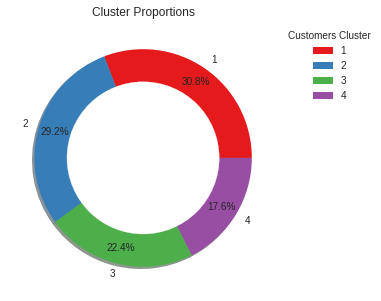

In [17]:
preds = model.predict(clean_df[features])
clusters = clean_df.copy()
clusters['Cluster'] = preds + 1

cluster_size = dict(clusters['Cluster'].value_counts())

plt.figure(figsize=(5, 5))
plt.title("Cluster Proportions")
plt.pie(cluster_size.values(), labels=sorted(cluster_size.keys()), 
        autopct="%.1f%%", pctdistance=0.85, shadow=True, 
        colors=sns.color_palette("Set1"))
plt.legend(title="Customers Cluster", labels=sorted(cluster_size.keys()), bbox_to_anchor=(1, 1))

donut = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(donut)

plt.show()

Clusters 1 and 2 have a similar number of customers. However, Cluster 1 beats Cluster 2 marginally.

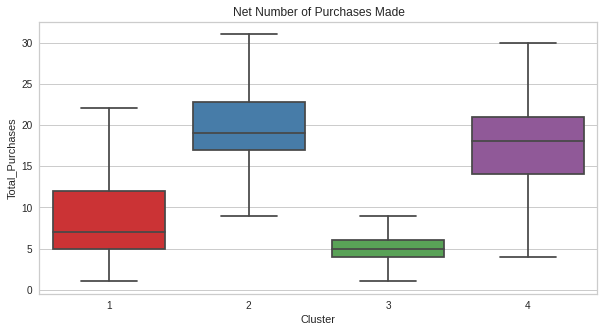

In [18]:
plt.figure(figsize=(10,5))
plt.title(f'Net Number of Purchases Made')
ax = sns.boxplot(data=clusters, x='Cluster', y='Total_Purchases', palette=sns.color_palette("Set1"), showfliers=False)
plt.show()

From the above box-whisker plots, we make the following inferences:

1.  **Cluster 1**: Low amount of purchases
2.  **Cluster 2:** Low amount of purchases
3. **Cluster 3:** Large amount of purchases
4.  **Cluster 4:** Considerable amount of purchases




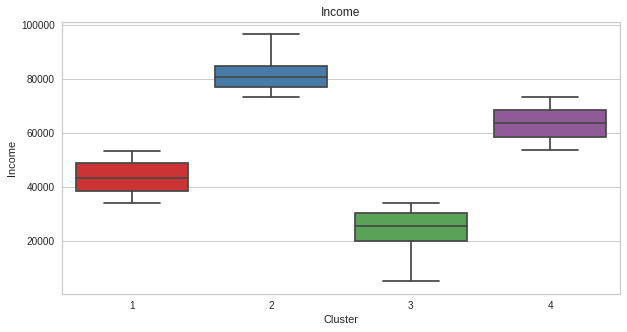

In [19]:
plt.figure(figsize=(10,5))
plt.title(f'Income')
axes = sns.boxplot(data=clusters, x='Cluster', y='Income', palette=sns.color_palette("Set1"), showfliers=False)
plt.show()

From the above box-whisker plots, we make the following inferences:
1.   **Cluster 1:** Medium income
2.   **Cluster 2:** Low Income
3.   **Cluster 3:** High income
4.   **Cluster 4:** Very high income

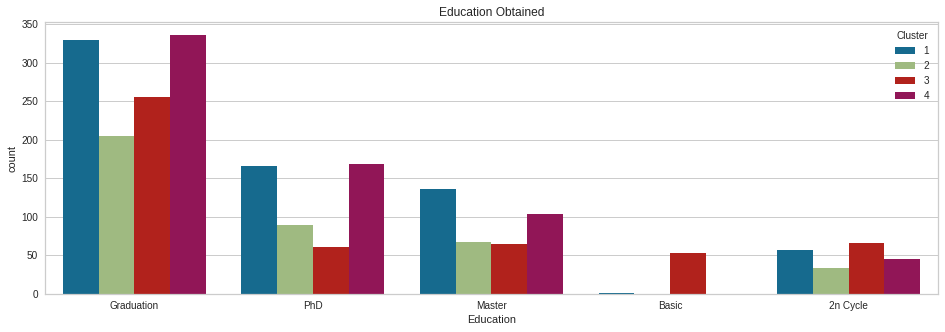

In [20]:
plt.figure(figsize=(16,5))
plt.title(f'Education Obtained')
sns.countplot(data=clusters, x='Education', hue='Cluster')
plt.show()

1.   **Graduation:** Cluster 4 
2.   **PhD Scholars:** Cluster 4
3.  **Masters Holders:** Cluster 1
4.  **Basic Education:** Cluster 3
5.  **2nd Cycle (European Masters):** Cluster 3

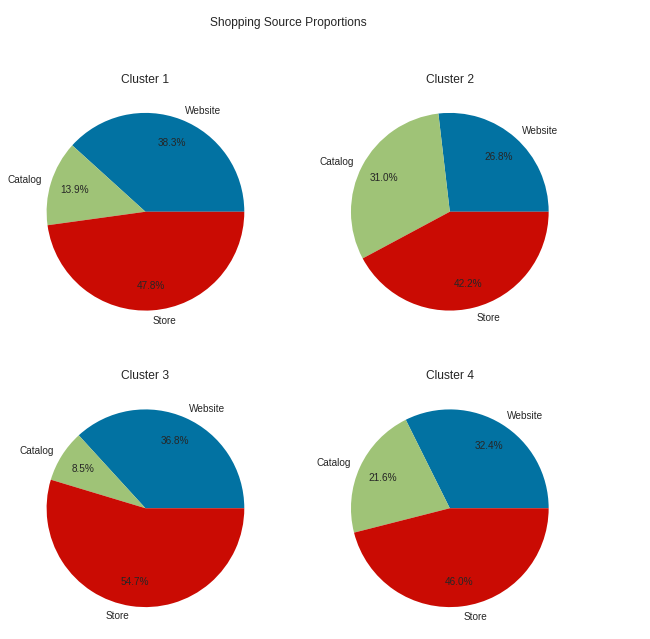

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))   
k = 0
for i in range(0, 2):
    for j in range(0, 2):
        k += 1
        num = clusters.query(f'Cluster == {k}').filter(regex='Num[^Deals|Total].+Purchases').sum(axis=0)
        sizes = dict(num)
        axes[i,j].set_title(f"Cluster {k}")
        axes[i,j].pie(sizes.values(), labels=['Website', 'Catalog', 'Store'], autopct="%.1f%%", pctdistance=0.75)

fig.suptitle('Shopping Source Proportions')
fig.legend(title="Shopping Source", labels=['Website', 'Catalog', 'Store'], bbox_to_anchor=(1,1)) 
fig.show()

All clusters make the maximum purchases at the store. Cluster 2 makes the maximum number of catalog purchases, possibly because catalogs are often released during the sale period.

# **KMeans Customer Analysis**



1.   **Platinum Customers: Cluster 4** (Highly educated, very high income, mostly buy from the store)
2.   **Diamond Customers: Cluster 3** (Well educated, high income, mostly buy from the store) 
3.   **Gold Customers: Cluster 1** (Educated, medium income, highest website purchases)
4.   **Silver Customers: Cluster 2** (Comaparatively lesser education, low income, highest catalog purchases)

Despite the increasing popularity of online shopping and e-commerce, most customers tend to purchase items from the shop. Running a shop can prove to be expensive due to added costs like rent, electricity, staffing, interiors, maintenance, etc. E-commerce is comparatively cheaper, and therefore, the company must focus on expanding its online presence, and bring in customers by introducing schemes that will attract them to online shopping.

# **Classification**

Classification is a supervised machine learning technique in which we determine if an instance belongs to a certain category based on the features of that instance. There are two types of classification:

1.   **Binomial Classification:** The instance can belong to one of two classes; for instance, 'will rain today' and 'will not rain today' are the only two possibilities that can occur, so any day will certainly belong to one of them.
2.   **Multinomial Classification:** The instance can belong to one of many classes; for instance, classifying the species of a flower.



In [119]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
from numpy import sort
from sklearn.feature_selection import SelectFromModel

First, the number of kids and teens at home was combined into a signle column for ease of use. Similarly, the total number of campaigns accepted by the customer was found by adding all the individual campaigns accepted. The data was checked for any null values - the Income feature had Null values which were then replaced with the median income of the dataset.

In [120]:
df['Childhome'] = df['Kidhome'] + df['Teenhome']
df['Total_Accepted_Cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] \
                            + df['AcceptedCmp4'] + df['AcceptedCmp5']
train_df = df.drop(['Education', 'Marital_Status', 'Dt_Customer', 'Kidhome', 
                    'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                   'AcceptedCmp4', 'AcceptedCmp5'], axis=1)
col_mask=train_df.isnull().any(axis=0) 
row_mask=train_df.isnull().any(axis=1)
#train_df.loc[row_mask,col_mask]

In [121]:
train_df[train_df == np.inf]=np.nan
train_df.fillna(train_df.median(), inplace=True)
#train_df.loc[row_mask,col_mask]

The XGBoost Classifier was initialised after the data was split into train and test data with respect to the total number of campaigns accepted by each customer. The test data size considered in this case was 20% of the original data.

The data was first trained with respect to the number of purchases made during during sales or deals.

In [122]:
X, y = train_df.loc[:, train_df.columns != 'NumDealsPurchases'], train_df['NumDealsPurchases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.62%


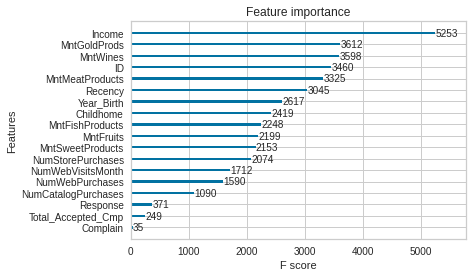

In [123]:
plot_importance(model)
plt.show()

We receive a poor accuracy score of 63.62%. There seems to be no significant relationship between the number of accepted campaigns by the customer, and the number of purchases they made during deals season.

In [124]:
X, y = train_df.loc[:, train_df.columns != 'Total_Accepted_Cmp'], train_df['Total_Accepted_Cmp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.93%


A decent accuracy score of 83.93% was achieved. The feature-wise impact on the accuracy score has been detailed below using the plot_importance function which is a part of the XGBoost model. 

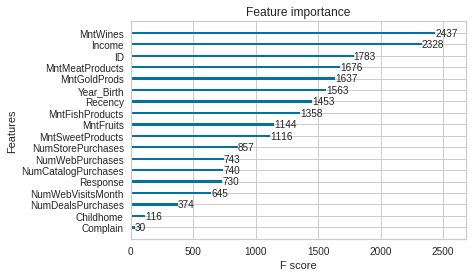

In [125]:
plot_importance(model)
plt.show()

From this visual, we are able to observe that the amount of money a customer spends on wine is a factor that hugely impacts the total number of campaigns the customer accepts. A close second factor is the income of the customer.

In [126]:
thresholds = sort(model.feature_importances_)
for threshold in thresholds:
    selection = SelectFromModel(model, threshold=threshold, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (threshold, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=21, Accuracy: 83.48%
Thresh=0.000, n=21, Accuracy: 83.48%
Thresh=0.000, n=21, Accuracy: 83.48%
Thresh=0.017, n=18, Accuracy: 83.48%
Thresh=0.040, n=17, Accuracy: 83.04%
Thresh=0.041, n=16, Accuracy: 82.81%
Thresh=0.041, n=15, Accuracy: 83.48%
Thresh=0.043, n=14, Accuracy: 82.81%
Thresh=0.044, n=13, Accuracy: 83.04%
Thresh=0.049, n=12, Accuracy: 83.93%
Thresh=0.050, n=11, Accuracy: 81.92%
Thresh=0.052, n=10, Accuracy: 83.26%
Thresh=0.052, n=9, Accuracy: 82.37%
Thresh=0.053, n=8, Accuracy: 81.03%
Thresh=0.054, n=7, Accuracy: 80.80%
Thresh=0.056, n=6, Accuracy: 81.47%
Thresh=0.057, n=5, Accuracy: 80.80%
Thresh=0.060, n=4, Accuracy: 79.91%
Thresh=0.063, n=3, Accuracy: 80.58%
Thresh=0.098, n=2, Accuracy: 80.36%
Thresh=0.128, n=1, Accuracy: 80.13%


By iteratively considering the number of features and comparing their accuracies, we are able to notice a decrease in the accuracy of the model with the number of features.

# **SHAP Analysis**

In [ ]:
!pip install shap

In [128]:
from sklearn.tree import export_graphviz
import shap 
import graphviz 

In [131]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0]) 

Force plots are suitable for row-wise SHAP analysis. It takes in a single row and shows in a rank order how each of the features contributed to the prediction. Wider a feature’s block, more is its contribution.




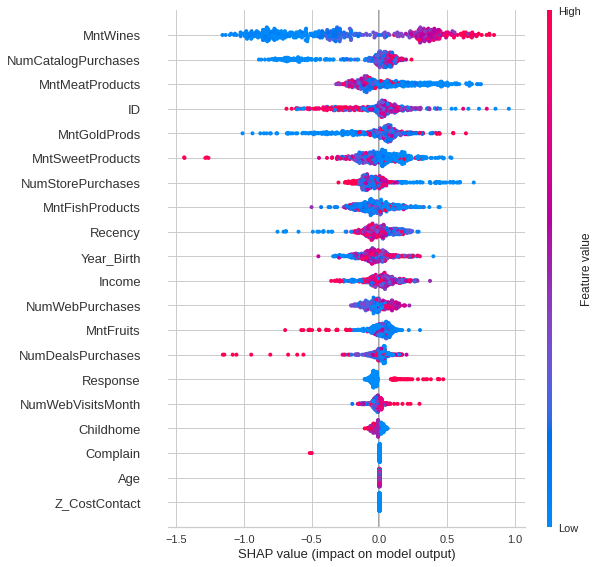

In [133]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

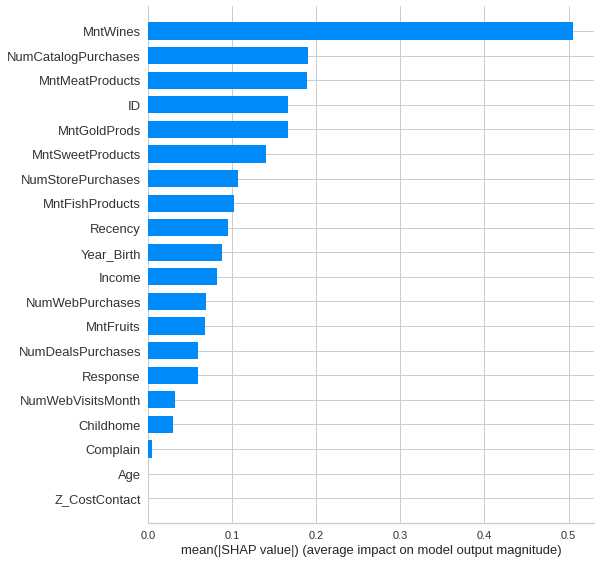

In [134]:
shap.summary_plot(shap_values[1], X_test, plot_type='bar')

# **Analysis of SHAP Results**

We can see from the bar plot that the amount of money a customer spends on wine is a huge determining factor of the campaigns they accept. It is possible that a lot of campaigns have been run for the alcoholic beverage department. It has been found earlier that families with children at home spend lesser money on wine - however, food items are a necessity. Running more campaigns on fruits and fish products will certainly be advantageous to more customers, thereby increasing profits.

Another noticeable observation is that the number of purchases made during deals has a very small impact on the total number of campaigns accepted. This may be an indication of lesser promotion of deals. By advertising deals, more customers will be interested in making purchases. 

Finally, it would be helpful to increase the internet presence of the company, as the number of purchases made from the website impacts the accepted campaigns very less. 